## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import strptime
import datetime
from datetime import datetime
import math
import warnings
warnings.filterwarnings('ignore')
import time
import csv
import glob
import logging
import importlib
import tweets_utils
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
from operator import itemgetter
import matplotlib.cm as mcm
import community
from community import community_louvain as cm
import leidenalg as la
import igraph as ig
from cdlib import algorithms
import plotly.express as px
%autosave 3600

Autosaving every 3600 seconds


## Indice
- [Utils](#utils)
- [CCDH and tweets process](#ccdh)
    - [Process CCDH data](#Process_CCDH_data)
    - [CCDH and Total tweets comparison](#comparison)
    - [Total stats](#stats) 
    - [Stats disinform](#stats_disinform)
    - [Network](#network)
    - [Botometer score](#botometer_score)

## Utils
<a id="utils"/>

In [2]:
def stats(total_len, original_len, retweet_len, reply_len):
    print(f'Number of total tweets: {total_len}')
    print(f'Number of original tweets: {original_len}')
    print(f'Number of retweet: {retweet_len}')
    print(f'Number of reply: {reply_len}')

    perc_original = np.around(original_len*100/total_len,2)
    perc_retweet = np.around(retweet_len*100/total_len,2)
    perc_reply = np.around(reply_len*100/total_len,2)
    print(f'Number of original_tweets: {perc_original}% of total tweets')
    print(f'Number of retweets: {perc_retweet}% of total tweets')
    print(f'Number of replies: {perc_reply}% of total tweets')

    print('Check sum == len(tweets): ',original_len + retweet_len + reply_len == total_len)

In [23]:
users_link = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/users_ccdh.csv")
users_disinform = pd.read_csv(users_link[0])
users_disinform

,screen_name,status
0,mercola,active
1,RobertKennedyJr,active
2,BusyDrT,suspended
3,DrButtar,active
4,unhealthytruth,active
5,DrChrisNorthrup,active
6,DrBenTapper1,suspended
7,kevdjenkins1,active


In [24]:
def found(name, list_name=users_disinform["screen_name"]):
    for i in list_name:
        if(name == i):
            return True
    return False

In [25]:
def print_pie_chart3(title, name1, name2, name3, len1, len2, len3):
    label = [name1, name2, name3]
    data = [len1, len2, len3]
    explode = (0.1, 0.1, 0.1)

    # Creating color parameters
    colors = ( "lightgreen", "orange", "cyan")

    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "black" }

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(data, 
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode, 
                                      labels = label,
                                      shadow = True,
                                      colors = colors,
                                      startangle = 90,
                                      wedgeprops = wp)

    # Adding legend
    ax.legend(wedges, label,
              title ="Legend",
              loc ="center left",
              bbox_to_anchor =(1, 0, 0.5, 1))

    plt.setp(autotexts, size = 8, weight ="bold")
    ax.set_title(title)
    plt.show()

In [26]:
def remove_www(url_list):
    urls_rt_beauty = []
    for i in url_list:
        value = i
        if "www" in i:
            splitted = i.split(".")
            value = splitted[1] + "." + splitted[2]
        urls_rt_beauty.append(value)
    return urls_rt_beauty

In [27]:
credibility_url = pd.read_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/credibility.csv")
credibility_url = credibility_url[["Domain", "Class"]]
credibility_url

,Domain,Class
0,100percentfedup.com,low
1,100percentfedup.com,high
2,10news.one,low
3,12minutos.com,low
4,12news.com,high
...,...,...
798,zapping2017.myblog.it,low
799,zazoom.it,low
800,zerohedge.com,low
801,ziare.com,low


In [11]:
def check_credibility(list_url, df = credibility_url):
    list_credibility = []
    for i in list_url:
        for j in range(len(df["Domain"])):
            if(i == df["Domain"][j]):
                list_credibility.append((i,df["Class"][j]))
    return list_credibility

## CCDH Research
<a id="ccdh"/>

### Process CCDH data
<a id="Process_CCDH_data"/>

In [6]:
disinform = pd.read_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/disinformation_users.csv")
disinform

,screen_name,status
0,mercola,active
1,RobertKennedyJr,active
2,TyCharleneB,removed
3,BusyDrT,suspended
4,IslamRizza,removed
5,DrButtar,active
6,unhealthytruth,active
7,sayerjigmi,active
8,KellyBroganMD,active
9,DrChrisNorthrup,active


In [13]:
names = []
status = []
for i in range(len(disinform["screen_name"])):
    print(disinform["screen_name"][i])
    if(disinform["screen_name"][i] in profile_name.values):
        names.append(disinform["screen_name"][i])
        status.append(disinform["status"][i])
print(names)
print(status)

mercola
RobertKennedyJr
TyCharleneB
BusyDrT
IslamRizza
DrButtar
unhealthytruth
sayerjigmi
KellyBroganMD
DrChrisNorthrup
DrBenTapper1
kevdjenkins1
['mercola', 'RobertKennedyJr', 'BusyDrT', 'DrButtar', 'unhealthytruth', 'DrChrisNorthrup', 'DrBenTapper1', 'kevdjenkins1']
['active', 'active', 'suspended', 'active', 'active', 'active', 'suspended', 'active']


In [14]:
with open("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/users_ccdh.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["screen_name","status"])
    for i in range(len(names)):
        writer.writerow([names[i], status[i]])

### CCDH and Total tweets comparison
<a id="comparison"/>

In [31]:
retweet_name = []
retweet_id = []
retweeted_name = []
retweeted_id = []
rt_link = []

tweet_name = []
tweet_id = []

# reply_id = []
# reply_name = []
# replied_id = []
# replied_name = []

link = []
result = []

# total_len = 0
# original_len = 0
# retweet_len = 0
# reply_len = 0
# d_total_len = 0
# d_original_len = 0
# d_retweet_len = 0
# d_reply_len = 0

cols_tweets = [u'user_screen_name',u'user_id', u'created_at', 
               u'urls', u"rt_created_at", u"rt_user_id", 
               u"rt_user_screen_name", u'in_reply_to_user_id', 
               u'in_reply_to_screen_name', u'in_reply_to_status_id']

files_tweets = glob.glob("F:/COVID-19-Tweets/*/tweets.csv")

In [32]:
for chunk in pd.read_csv(files_tweets[0], chunksize=10, lineterminator = '\n'):
    break
# chunk.info()

In [33]:
importlib.reload(tweets_utils)
start_time = time.perf_counter()
j = 0
for filename in files_tweets:
    print(f"Reading file: {filename}")
    result.extend(tweets_utils.process_all_data(filename, cols_tweets, True, users_disinform["screen_name"]))
    lista = result[j]
    j = j + 1
    print(f"Mese numero {j}")
#     x = 0
#     y = 0
    for i in range(len(lista)):
        #original post
        tweet_name.extend(lista[i]["original_names"])
        tweet_id.extend(lista[i]["original_ids"])
        link.extend(lista[i]["links"])
#         #user who retweet
        retweet_name.extend(lista[i]["retweet_users"])
        retweet_id.extend(lista[i]["retweet_ids"])
#         #user retweeted
        retweeted_name.extend(lista[i]["retweeted_users"])
        retweeted_id.extend(lista[i]["retweeted_ids"])
        rt_link.extend(lista[i]["rt_link"])
# #         #user who reply
#         reply_id.extend(lista[i]["reply_ids"])
#         reply_name.extend(lista[i]["reply_users"])
# #         #use who get reply
#         replied_id.extend(lista[i]["replied_ids"])
#         replied_name.extend(lista[i]["replied_users"])
#         #len
#         total_len = total_len + lista[i]["total_len"]
#         original_len = original_len + lista[i]["original_len"]
#         retweet_len = retweet_len + lista[i]["retweet_len"]
#         reply_len = reply_len + lista[i]["reply_len"]
        
#         d_total_len = d_total_len + lista[i]["d_total_len"]
#         d_original_len = d_original_len + lista[i]["d_original_len"]
#         d_retweet_len = d_retweet_len + lista[i]["d_retweet_len"]
#         d_reply_len = d_reply_len + lista[i]["d_reply_len"]
#         print(i)
#         print("-")
#         if(i == 0):
#             x = 0
#         else:
#             x = y
#         y = x + len(lista[i]["users"])
#         for q in range(x,y):
#             if(found(lista[i]["users"][q])):          
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Reading file: F:/COVID-19-Tweets\2020-01\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Mese numero 1
Reading file: F:/COVID-19-Tweets\2020-02\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Mese numero 2
Reading file: F:/COVID-19-Tweets\2020-03\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Mese numero 3
Reading file: F:/COVID-19-Tweets\2020-04\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7


In [34]:
del result
del lista

In [35]:
df_rt_ccdh = pd.DataFrame(list(zip(retweet_id, retweet_name, retweeted_id, retweeted_name, rt_link)), 
                          columns =['id','name', 'rt_id','rt_name', 'rt_url'])

In [74]:
gephi = pd.DataFrame(list(zip(retweet_name, retweeted_name)), 
                          columns =['name','rt_name'])
gephi.to_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/gephi.csv", index=False)

In [42]:
df_rt_ccdh.to_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/ccdh_user_rt.csv", index=False)

In [43]:
df_rt_ccdh

,id,name,rt_id,rt_name,rt_url
0,1.104760e+18,Exvaxxer_Mommy,18093097.0,unhealthytruth,[]
1,1.055931e+18,patriot7842,18093097.0,unhealthytruth,[]
2,2.282256e+07,dihoppy,18093097.0,unhealthytruth,[]
3,4.182128e+07,liteseeker,18093097.0,unhealthytruth,[]
4,7.150825e+08,Heidi559Heidi,18093097.0,unhealthytruth,[]
...,...,...,...,...,...
3524,1.163569e+18,Nomoresilence20,337808606.0,RobertKennedyJr,[]
3525,1.082425e+18,Warrior17761,35013035.0,BusyDrT,[]
3526,8.863322e+06,TonyGosling,337808606.0,RobertKennedyJr,[]
3527,1.206716e+18,banka_beata,35013035.0,BusyDrT,[]


### Total stats 
<a id="stats"/>

In [14]:
stats(total_len, original_len, retweet_len, reply_len)

Number of total tweets: 66412411
Number of original tweets: 13999715
Number of retweet: 48312504
Number of reply: 4100192
Number of original_tweets: 21.08% of total tweets
Number of retweets: 72.75% of total tweets
Number of replies: 6.17% of total tweets
Check sum == len(tweets):  True


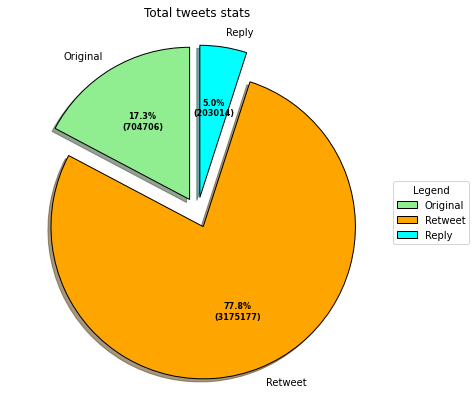

In [26]:
print_pie_chart3("Total tweets stats","Original","Retweet", "Reply", original_len, retweet_len, reply_len)

### Stats disinform
<a id="stats_disinform"/>

In [36]:
stats(d_total_len, d_original_len, d_retweet_len, d_reply_len)

Number of total tweets: 3766
Number of original tweets: 75
Number of retweet: 3513
Number of reply: 178
Number of original_tweets: 1.99% of total tweets
Number of retweets: 93.28% of total tweets
Number of replies: 4.73% of total tweets
Check sum == len(tweets):  True


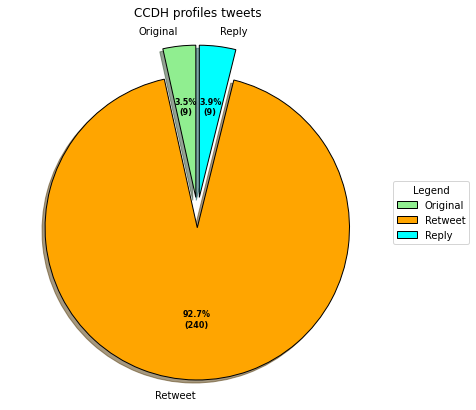

In [32]:
print_pie_chart3("CCDH profiles tweets","Original","Retweet", "Reply", d_original_len, d_retweet_len, d_reply_len)

### URL investigation

In [51]:
urls = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in link]
urls = list(filter(lambda num: num != "0", urls))
urls_rt = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in rt_link]
urls_rt = list(filter(lambda num: num != "0", urls_rt))
urls = remove_www(urls)
urls_rt = remove_www(urls_rt)
# date = [tweets_utils.process_datetime(v) for v in data]

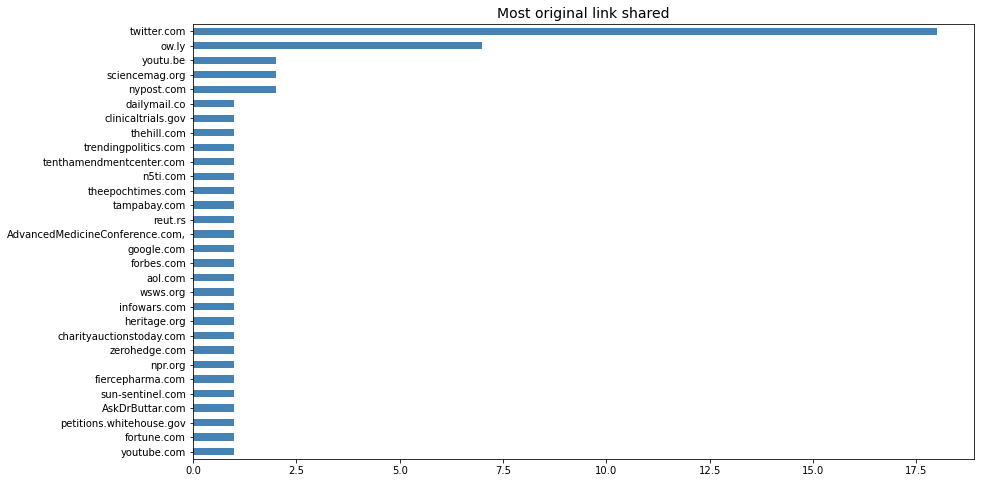

In [52]:
val = pd.Series(urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:30].plot(kind='barh', color='steelblue', fig=(14,14))
ax.set_title('Most original link shared', fontsize=14)
ax.invert_yaxis()
plt.show()

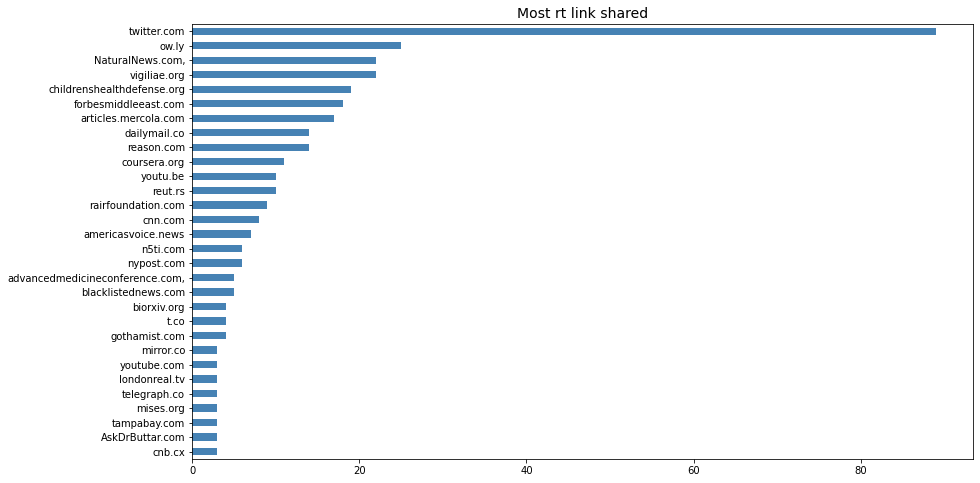

In [54]:
val = pd.Series(urls_rt).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:30].plot(kind='barh', color='steelblue', fig=(14,14))
ax.set_title('Most rt link shared', fontsize=14)
ax.invert_yaxis()
plt.show()

In [60]:
urls_rt = list(set(urls_rt))

In [76]:
credibility_url

,Domain,Class
0,100percentfedup.com,low
1,100percentfedup.com,high
2,10news.one,low
3,12minutos.com,low
4,12news.com,high
...,...,...
798,zapping2017.myblog.it,low
799,zazoom.it,low
800,zerohedge.com,low
801,ziare.com,low


In [61]:
urls_rt

['biorxiv.org',
 'uncoverdc.com',
 'deepstatejournal.com',
 'rairfoundation.com',
 'wnd.com',
 'vaxxter.com',
 'americasvoice.news',
 'dailymail.co',
 'chinaopticsvalley.com',
 'youtube.com',
 'mirror.co',
 'google.com',
 'latimes.com',
 'nbcnews.com',
 'cogforlife.org',
 'independent.co',
 'nypost.com',
 'kxly.com',
 'childrenshealthdefense.org',
 't.co',
 'brighteon.com',
 'activistpost.com',
 'cbsnews.com',
 'telegraph.co',
 'articles.mercola.com',
 'forbesmiddleeast.com',
 'vigiliae.org',
 'blacklistednews.com',
 'reason.com',
 'coursera.org',
 'cnn.com',
 'everydayconcerned.net',
 'nytimes.com',
 'healthnutnews.com',
 'wxyz.com',
 'thesun.co',
 'trendingpolitics.com',
 'youtu.be',
 'tenthamendmentcenter.com',
 'mises.org',
 'n5ti.com',
 'reut.rs',
 'tampabay.com',
 'londonreal.tv',
 'gothamist.com',
 'theepochtimes.com',
 'healthimpactnews.com',
 'Military.com,',
 'twitter.com',
 'medicalxpress.com',
 'theconservativebrief.com',
 'fortune.com',
 'NaturalNews.com,',
 'AskDrButtar.c

In [64]:
val = 0
for i in credibility_url["Domain"]:
    for j in urls_rt:
        if i == j:
            print(i)
            val = val + 1
x = len(urls_rt) - val
print(f"Missing urls: {x}")

activistpost.com
cbsnews.com
cnb.cx
cnn.com
fortune.com
latimes.com
medicalxpress.com
nbcnews.com
nypost.com
nytimes.com
reut.rs
wnd.com
wnd.com
Missing urls: 44


In [65]:
urls_rt

['biorxiv.org',
 'uncoverdc.com',
 'deepstatejournal.com',
 'rairfoundation.com',
 'wnd.com',
 'vaxxter.com',
 'americasvoice.news',
 'dailymail.co',
 'chinaopticsvalley.com',
 'youtube.com',
 'mirror.co',
 'google.com',
 'latimes.com',
 'nbcnews.com',
 'cogforlife.org',
 'independent.co',
 'nypost.com',
 'kxly.com',
 'childrenshealthdefense.org',
 't.co',
 'brighteon.com',
 'activistpost.com',
 'cbsnews.com',
 'telegraph.co',
 'articles.mercola.com',
 'forbesmiddleeast.com',
 'vigiliae.org',
 'blacklistednews.com',
 'reason.com',
 'coursera.org',
 'cnn.com',
 'everydayconcerned.net',
 'nytimes.com',
 'healthnutnews.com',
 'wxyz.com',
 'thesun.co',
 'trendingpolitics.com',
 'youtu.be',
 'tenthamendmentcenter.com',
 'mises.org',
 'n5ti.com',
 'reut.rs',
 'tampabay.com',
 'londonreal.tv',
 'gothamist.com',
 'theepochtimes.com',
 'healthimpactnews.com',
 'Military.com,',
 'twitter.com',
 'medicalxpress.com',
 'theconservativebrief.com',
 'fortune.com',
 'NaturalNews.com,',
 'AskDrButtar.c

In [67]:
list_credibility_original = check_credibility(urls)
list_credibility_rt = check_credibility(urls_rt)

In [77]:
list_credibility_rt

[('wnd.com', 'low'),
 ('wnd.com', 'high'),
 ('latimes.com', 'high'),
 ('nbcnews.com', 'high'),
 ('nypost.com', 'high'),
 ('activistpost.com', 'low'),
 ('cbsnews.com', 'high'),
 ('cnn.com', 'high'),
 ('nytimes.com', 'high'),
 ('reut.rs', 'high'),
 ('medicalxpress.com', 'high'),
 ('fortune.com', 'high'),
 ('cnb.cx', 'high')]

### Network
<a id="network" />

In [44]:
retweets_graph = nx.from_pandas_edgelist(df_rt_ccdh,'name','rt_name', create_using=nx.DiGraph())
print(nx.info(retweets_graph))

Name: 
Type: DiGraph
Number of nodes: 2545
Number of edges: 2743
Average in degree:   1.0778
Average out degree:   1.0778


In [45]:
isolated_nodes = list(nx.isolates(retweets_graph))
print('Isoleted nodes:',len(isolated_nodes))

Isoleted nodes: 0


In [46]:
print('Strongly connected: ',nx.is_strongly_connected(retweets_graph))

Strongly connected:  False


In [47]:
print('Number of connected components: ',nx.number_strongly_connected_components(retweets_graph))

Number of connected components:  2545


In [48]:
# Extract the giant connected component
Gcc = sorted((retweets_graph.subgraph(c) for c in nx.strongly_connected_components(retweets_graph)), key = len,reverse=True)[0]
print("Number of nodes in the Gcc graph: ")
print(len(Gcc.nodes()))
print("Number of edges in the Gcc graph: ")
print(len(Gcc.edges()))

Number of nodes in the Gcc graph: 
1
Number of edges in the Gcc graph: 
1


In [49]:
degrees = [val for (node, val) in retweets_graph.degree()]

print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

out_degrees = [val for (node, val) in retweets_graph.out_degree()]

print(f"The maximum out_degree of the Graph is {np.max(out_degrees)}")   
print(f"The minimum out_degree of the Graph is {np.min(out_degrees)}")

in_degrees = [val for (node, val) in retweets_graph.in_degree()]

print(f"The maximum in_degree of the Graph is {np.max(in_degrees)}")   
print(f"The minimum in_degree of the Graph is {np.min(in_degrees)}")

The maximum degree of the Graph is 1276
The minimum degree of the Graph is 1
The maximum out_degree of the Graph is 5
The minimum out_degree of the Graph is 0
The maximum in_degree of the Graph is 1275
The minimum in_degree of the Graph is 0


In [50]:
density = nx.density(retweets_graph)
print("Network density:", density)

Network density: 0.00042366336756002025


In [51]:
degree_dict = dict(retweets_graph.degree(retweets_graph.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [52]:
n=5
print("Top n nodes by degree:")
for d in sorted_degree[:n]:
    print(f"the node with name {d[0]} , has a degree of {d[1]}")

Top n nodes by degree:
the node with name BusyDrT , has a degree of 1276
the node with name RobertKennedyJr , has a degree of 581
the node with name DrButtar , has a degree of 417
the node with name mercola , has a degree of 269
the node with name unhealthytruth , has a degree of 178


In [53]:
in_degree_dict = dict(retweets_graph.in_degree(retweets_graph.nodes()))
sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)

In [54]:
n=5
print("Top n nodes by in_degree:")
for d in sorted_in_degree[:n]:
    print(f"the node with name {d[0]} , has a in-degree of {d[1]}")

Top n nodes by in_degree:
the node with name BusyDrT , has a in-degree of 1275
the node with name RobertKennedyJr , has a in-degree of 580
the node with name DrButtar , has a in-degree of 417
the node with name mercola , has a in-degree of 269
the node with name unhealthytruth , has a in-degree of 177


In [55]:
out_degree_dict = dict(retweets_graph.out_degree(retweets_graph.nodes()))
sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)

In [56]:
n=5
print("Top n nodes by out_degree:")
for d in sorted_out_degree[:n]:
    print(f"the node with name {d[0]} , has a out-degree of {d[1]}")

Top n nodes by out_degree:
the node with name patriot7842 , has a out-degree of 5
the node with name BarryB911 , has a out-degree of 4
the node with name frLarousse2 , has a out-degree of 4
the node with name dad_liams , has a out-degree of 3
the node with name mother_verge , has a out-degree of 3


In [57]:
graph_centrality = nx.degree_centrality(retweets_graph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(retweets_graph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(retweets_graph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id BusyDrT has a degree centrality of 0.50 which is the maximum of the Graph
the node with id BusyDrT has a closeness centrality of 0.50 which is the maximum of the Graph
the node with id kevdjenkins1 has a betweenness centrality of 0.00 which is the maximum of the Graph


In [58]:
#pageRank centrality for each node
pagerank_centr = nx.pagerank(retweets_graph)

#### Communities with Louvain modularity

In [59]:
retweets_graph_und = nx.from_pandas_edgelist(df_rt_ccdh,'name','rt_name')
print(nx.info(retweets_graph_und))

Name: 
Type: Graph
Number of nodes: 2545
Number of edges: 2743
Average degree:   2.1556


In [60]:
best_part = cm.best_partition(retweets_graph_und, random_state=42)

In [61]:
size = float(len(set(best_part.values())))
print("Number of communities: ", size)

Number of communities:  7.0


In [62]:
#check that sum of each community size = number of nodes
communities_size = np.zeros(len(set(best_part.values())))
for v in list(best_part.values()):
    communities_size[v] +=1
print(sum(communities_size))

2545.0


In [63]:
print("Louvain Modularity: ",cm.modularity(best_part, retweets_graph_und))

Louvain Modularity:  0.6489055294562808


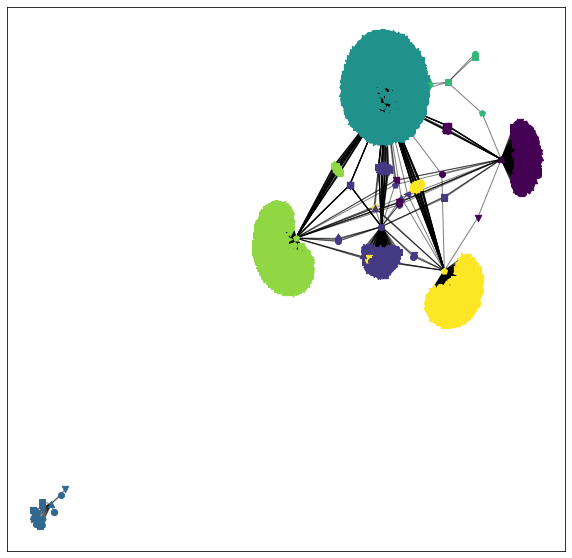

In [64]:
# color the nodes according to their partition
pos = nx.spring_layout(retweets_graph_und)

plt.figure(figsize=(10,10)) 
cmap = mcm.get_cmap('viridis', max(best_part.values()) + 1)
shapes = 'so^>v<dph8'
shapes_iter = 0
for node, color in best_part.items():
    nx.draw_networkx_nodes(retweets_graph_und, pos, [node], node_size=40,
                           node_color=[cmap.colors[color]],
                           node_shape=shapes[shapes_iter])
    shapes_iter +=1
    if shapes_iter == len(shapes):
        shapes_iter=0
nx.draw_networkx_edges(retweets_graph_und, pos, alpha=0.5)
#plt.savefig('plots/communities')
plt.show() #add labels

#### Communities with Leiden

In [65]:
tuples = [tuple(x) for x in df_rt_ccdh.values]
retweets_graph = ig.Graph.TupleList(tuples, directed = True)

In [66]:
n_vertices = retweets_graph.vcount()
print("Number of vertices:", n_vertices)
print("Number of edges:", retweets_graph.ecount())
print("Density of the graph:", 2*retweets_graph.ecount()/(retweets_graph.vcount()*(retweets_graph.vcount()-1)))

Number of vertices: 5085
Number of edges: 3529
Density of the graph: 0.00027301414892538876


In [67]:
total_degree=0
total_indegree = 0
total_outdegree = 0
for n in range(n_vertices):
    total_degree += retweets_graph.degree(n)
    total_indegree += retweets_graph.indegree(n)
    total_outdegree += retweets_graph.outdegree(n)
print("Average indegree:", total_indegree/n_vertices)
print("Average indegree:", total_outdegree/n_vertices)

Average indegree: 0.6940019665683382
Average indegree: 0.6940019665683382


In [68]:
partition = la.find_partition(retweets_graph, la.ModularityVertexPartition)
partition

In [69]:
retweets_graph.vs[0]['name']

1.104759620495704e+18

In [70]:
retweets_graph.vs()["name"]

[1.104759620495704e+18,
 'Exvaxxer_Mommy',
 1.0559308951259382e+18,
 'patriot7842',
 22822556.0,
 'dihoppy',
 41821282.0,
 'liteseeker',
 715082513.0,
 'Heidi559Heidi',
 18093097.0,
 'unhealthytruth',
 707224081.0,
 'CarolynRude',
 1147408314.0,
 'Samm_LM',
 79789868.0,
 'monis1013',
 494684963.0,
 'janeausten1961',
 8.210219462845604e+17,
 'argounova',
 3403248579.0,
 'VeritasDolor',
 1.1665387983957975e+18,
 'Ashleywarrior12',
 7.589716312932147e+17,
 'GreySouthwick',
 9.003649825708442e+17,
 'JMctalk',
 7.751370937733652e+17,
 'ReussMichele',
 735101078.0,
 'TheGalvinGang',
 4829675178.0,
 'jimbarrack',
 2312879312.0,
 'atruthdetective',
 275397354.0,
 'nakatsu28',
 74927053.0,
 'enemama',
 2742039033.0,
 'davelikestorave',
 3301042497.0,
 'MariMagforever',
 4215316033.0,
 'wakeup_patriot',
 1.1386194576711803e+18,
 'Elizabe07423174',
 1.2026151773608714e+18,
 'KarinaRa1776',
 2409506407.0,
 'Athbheochan',
 24861271.0,
 'katedish',
 1.0958948112387809e+18,
 'AdiMano2',
 56569304.0,


In [71]:
partition.membership

[1,
 1,
 2,
 2,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 20,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 25,
 25,
 26,
 26,
 27,
 27,
 28,
 28,
 29,
 29,
 30,
 30,
 31,
 31,
 32,
 32,
 33,
 33,
 34,
 34,
 35,
 35,
 36,
 36,
 37,
 37,
 38,
 38,
 39,
 39,
 40,
 40,
 41,
 41,
 42,
 42,
 43,
 43,
 44,
 44,
 45,
 45,
 46,
 46,
 47,
 47,
 48,
 48,
 49,
 49,
 50,
 50,
 51,
 51,
 52,
 52,
 53,
 53,
 54,
 54,
 55,
 55,
 56,
 56,
 57,
 57,
 58,
 58,
 59,
 59,
 60,
 60,
 61,
 61,
 62,
 62,
 63,
 63,
 64,
 64,
 65,
 65,
 66,
 66,
 67,
 67,
 68,
 68,
 69,
 69,
 70,
 70,
 71,
 71,
 72,
 72,
 73,
 73,
 74,
 74,
 75,
 75,
 76,
 76,
 77,
 77,
 78,
 78,
 79,
 79,
 80,
 80,
 81,
 81,
 82,
 82,
 83,
 83,
 84,
 84,
 85,
 85,
 86,
 86,
 87,
 87,
 88,
 88,
 89,
 89,
 90,
 90,
 91,
 91,
 92,
 92,
 93,
 93,
 94,
 94,
 95,
 95,
 96,
 96,
 97,
 97,
 98,
 98,
 99,
 99,
 100,
 100,
 101,
 101,
 102

In [72]:
zip_iterator = zip(retweets_graph.vs()["name"], partition.membership)
best_part = dict(zip_iterator)
best_part

{1.104759620495704e+18: 1,
 'Exvaxxer_Mommy': 1,
 1.0559308951259382e+18: 2,
 'patriot7842': 2,
 22822556.0: 3,
 'dihoppy': 3,
 41821282.0: 4,
 'liteseeker': 4,
 715082513.0: 5,
 'Heidi559Heidi': 5,
 18093097.0: 6,
 'unhealthytruth': 6,
 707224081.0: 7,
 'CarolynRude': 7,
 1147408314.0: 8,
 'Samm_LM': 8,
 79789868.0: 9,
 'monis1013': 9,
 494684963.0: 10,
 'janeausten1961': 10,
 8.210219462845604e+17: 11,
 'argounova': 11,
 3403248579.0: 12,
 'VeritasDolor': 12,
 1.1665387983957975e+18: 13,
 'Ashleywarrior12': 13,
 7.589716312932147e+17: 14,
 'GreySouthwick': 14,
 9.003649825708442e+17: 15,
 'JMctalk': 15,
 7.751370937733652e+17: 16,
 'ReussMichele': 16,
 735101078.0: 17,
 'TheGalvinGang': 17,
 4829675178.0: 18,
 'jimbarrack': 18,
 2312879312.0: 19,
 'atruthdetective': 19,
 275397354.0: 20,
 'nakatsu28': 20,
 74927053.0: 21,
 'enemama': 21,
 2742039033.0: 22,
 'davelikestorave': 22,
 3301042497.0: 23,
 'MariMagforever': 23,
 4215316033.0: 24,
 'wakeup_patriot': 24,
 1.1386194576711803e+

### Botometer Score
<a id="botometer_score"/>

In [91]:
import botometer
import json
import tweepy
file_config = open('config.json',)
data = json.load(file_config)

rapidapi_key = data["key_rapidapi"]
twitter_app_auth = {
    'consumer_key': data["consumer_key"],
    'consumer_secret': data["consumer_secret"],
    'access_token': data["access_token"],
    'access_token_secret': data["access_token_secret"]
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)


In [85]:
result = []
for i in range(len(retweet_name)//2):
    username = "@" + retweet_name.keys()[i]
    try:
        score = bom.check_account(username)
        print(f"scored {i}, {username}")
        result.append(score)
    except tweepy.TweepError as e:
        print(e)
        print('Account %s'%username)